# Clustering de documents

## Imports

In [33]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [34]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
data_path = "../data/txt/"

## Choisir une décennie

In [36]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [37]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [38]:
# Exemple de fichiers
files[:35]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt',
 'KB_JB838_1950-01-22_01-00014.txt',
 'KB_JB838_1950-02-13_01-00005.txt',
 'KB_JB838_1950-02-13_01-00008.txt',
 'KB_JB838_1950-02-15_01-00011.txt',
 'KB_JB838_1950-02-15_01-00014.txt',
 'KB_JB838_1950-02-16_01-00014.txt',
 'KB_JB838_1950-02-17_01-00009.txt',
 'KB_JB838_1950-02-18_01-00009.txt',
 'KB_JB838_1950-02-18_01-00014.txt',
 'KB_JB838_1950-02-25_01-00006.txt',
 'KB_JB838_1950-02-25_01-00013.txt',
 'KB_JB838_1950-02-28_01-00012.txt',
 'KB_JB838_1950-03-01_01-00005.txt',
 'KB_JB838_1950-03-03_01-00013.txt',
 'KB_JB838_1950-03-05_01-00020.txt',
 'KB_JB838_1950-03-11_01-00005.txt',
 'KB_JB838_1950-03-15_01-00012.txt',
 'KB_JB838_1950-03-19_01-00001.txt',
 'KB_JB838_1950-03-25_01-00009.txt',
 'KB_JB838_1950-03-27_01-00002.txt',
 'KB_JB838_1950-03-29_01-00002.txt',
 'KB_JB838_1950-03-29_01-00008.txt',
 

In [39]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [40]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [41]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [42]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [43]:
tfidf_vectors = vectorizer.fit_transform(texts)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
# Détail de la matrice
tfidf_vectors

<1000x3506 sparse matrix of type '<class 'numpy.float64'>'
	with 703537 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [45]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

parti           0.276938
loyer           0.152177
janvier         0.148006
populaire       0.147153
propriétaire    0.143666
                  ...   
habitants       0.000000
agit            0.000000
haecht          0.000000
hainaut         0.000000
#               0.000000
Length: 3506, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [46]:
cosine([1, 2, 3], [1, 2, 3])

0

In [47]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [48]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [49]:
tfidf_array = tfidf_vectors.toarray()

In [50]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03783743])

In [51]:
# Vecteur du document 1
tfidf_array[1]

array([0.       , 0.0067047, 0.       , ..., 0.       , 0.       ,
       0.       ])

In [52]:
cosine(tfidf_array[0], tfidf_array[1])

0.9314339868905285

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [53]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [54]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [55]:
clusters = km_model.fit_predict(tfidf_vectors)

In [56]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [57]:
pprint(dict(clustering))

{0: ['KB_JB838_1950-01-06_01-00002.txt',
     'KB_JB838_1950-01-10_01-00006.txt',
     'KB_JB838_1950-01-15_01-00010.txt',
     'KB_JB838_1950-02-13_01-00005.txt',
     'KB_JB838_1950-02-13_01-00008.txt',
     'KB_JB838_1950-02-17_01-00009.txt',
     'KB_JB838_1950-02-18_01-00009.txt',
     'KB_JB838_1950-02-25_01-00006.txt',
     'KB_JB838_1950-03-01_01-00005.txt',
     'KB_JB838_1950-03-05_01-00020.txt',
     'KB_JB838_1950-03-11_01-00005.txt',
     'KB_JB838_1950-03-19_01-00001.txt',
     'KB_JB838_1950-03-25_01-00009.txt',
     'KB_JB838_1950-03-27_01-00002.txt',
     'KB_JB838_1950-03-29_01-00002.txt',
     'KB_JB838_1950-03-31_01-00006.txt',
     'KB_JB838_1950-04-19_01-00002.txt',
     'KB_JB838_1950-04-26_01-00007.txt',
     'KB_JB838_1950-05-03_01-00006.txt',
     'KB_JB838_1950-05-07_01-00002.txt',
     'KB_JB838_1950-05-16_01-00003.txt',
     'KB_JB838_1950-05-29_01-00002.txt',
     'KB_JB838_1950-06-04_01-00011.txt',
     'KB_JB838_1950-06-10_01-00010.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [58]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [59]:
reduced_vectors[:10]

array([[-0.32580699,  0.11404391],
       [ 0.11344714, -0.30211037],
       [ 0.44352734, -0.25255174],
       [-0.23898552, -0.03761818],
       [-0.05189779, -0.10505035],
       [ 0.61297815,  0.50406055],
       [-0.2041063 , -0.0350842 ],
       [-0.19454706, -0.03815636],
       [ 0.62392888,  0.45588676],
       [ 0.15642298, -0.01433015]])

### Générer le plot

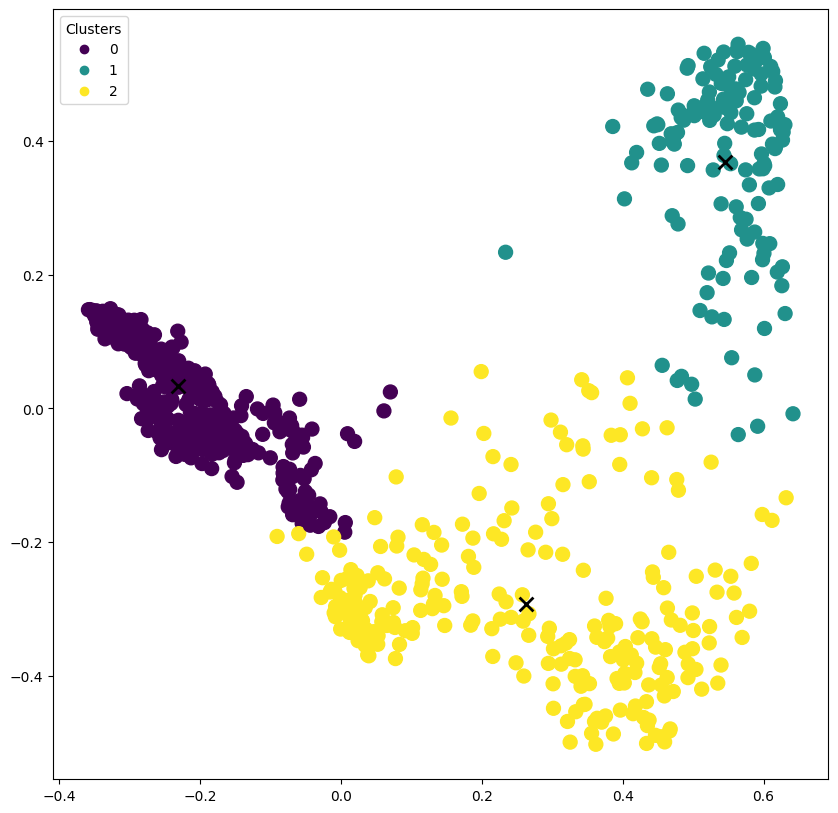

In [60]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")